<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/10-autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autograd

In [1]:
!pip install --quiet torchviz

  Preparing metadata (setup.py) ... done


In [28]:
import numpy as np
import torch

from IPython.display import display
import torchviz

In [29]:
for c in [np, torch]:
  print(c.__name__, c.__version__)

numpy 1.25.2
torch 2.2.1+cu121


## 1. `requires_grad`를 True로 설정
- tensor 연산 추적, 자동으로 gradient 계산

In [30]:
x_np = np.arange(-1, 1, 0.5)

x = torch.tensor(x_np, dtype=torch.float32)
x.requires_grad = True

display(x)

tensor([-1.0000, -0.5000,  0.0000,  0.5000], requires_grad=True)

## Autograd 관련 attributes

### x.is_leaf
- 계산 그래프에서 “leaf node"인지 여부를 나타냄.
- leaf node: 직접 생성된 tensor.
- 만약 tensor 가 다른 tensor로부터 어떤 연산을 통해 생성되었다면, is_leaf 속성은 `False`임.

### x.grad_fn
- 텐서가 다른 텐서들의 연산을 통해 생성된 경우(=leaf node가 아닌 경우) 해당 연산을 나타냄.
- 이를 통해 back-propagation 에서 gradient를 계산할 때 어떤 연산을 통해 편미분을 계산하는지 알 수 있음.

### x.grad
- tensor 인스턴스 x 에 대해 수행된 마지막 `.backward()` 연산으로부터 계산된 gradient가 저장됨.
- x의 `requires_grad = True`일 때,
  - PyTorch는 x에 대한 모든 연산 추적
  - `.backward()`가 호출될 때 자동으로 gradient를 계산하여 `x.grad에` 저장
- 만약 x가 scalar가 아닌 경우, `.backward()` 호출 시 gradient의 shape를 지정하는 argument를 전달해야함
(`.backward()`를 호출하는 tensor와 같은 shape 이며 각 요소로 scalar 1을 가지는 tensor 인스턴스가 주로 argument로 사용됨.)

## 2. tensor 인스턴스에 대한 연산 기재
`requires_grad=True`인 경우 not working (`.detach()` 필요.)

- `requires_grad=True`인 tensor 인스턴스에 연결된 모든 tensor 인스턴스도 다 `requires_grad=True` 임.
- 맨 처음 `requires_grad=True` 로 지정한 tensor 인스턴스는 `is_leaf`는 True로 설정되고, 이후 해당 인스턴스에 연결되는 Tensor들은 False 임.
- 이들 연결된 tensor들의 `grad_fn` 에 Backward function이 할당됨

leaf node 가 아닌 다른 tensor 와 연산으로 만들어진 tensor 인스턴스에 대해
Gradient를 구하고 싶을때는 해당 tensor 인스턴스의 메서드 `.retain_grad()`를
.backward() 호출 전에 호출하면 됨: <br>
이를 통해 해당 tensor 인스턴스의 gradient를 "유지"하게 됨.



In [31]:
y = 3 * x + 10

display(y)

tensor([ 7.0000,  8.5000, 10.0000, 11.5000], grad_fn=<AddBackward0>)

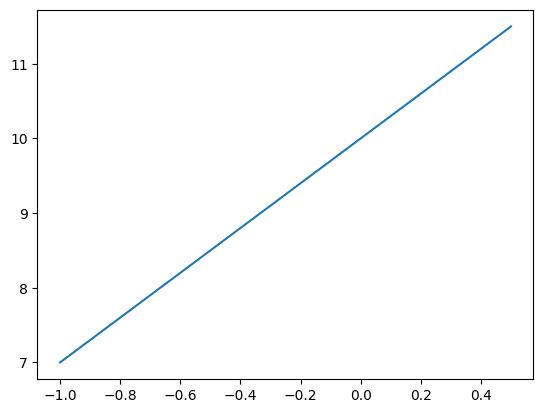

In [32]:
import matplotlib.pyplot as plt

# plt.plot(x, y) # requires_grad=True인 경우 not working (.detach 필요.)
plt.plot(x.detach().numpy(), y.detach().numpy()) # requires_grad=True인 경우 not working

## 3. Back-propagation 수행

### **초기화**
**Training 과정 중 "한 번의 iteration (단일 batch에 대해)"이 끝난 후에는 grad 를 0으로 초기화해야 함.**
- grad 를 초기화하지 않으면, 각 batch에 대한 grad가 누적되어 parameter가 잘못 update되고 제대로 학습이 이루어지지 않음.
- training loop 에서 `x.grad.zero_()` 또는 `optimizer.zero_grad()`를 호출하여 gradient를 초기화함.


### **과정**
- backpropagation이 시작되는 loss function의 결과 Tensor 인스턴스 ( b )에서
backward() 메서드를 수행하여 gradient 계산.
- computational graph의 leaf node의 attribute 인 .grad 에 계산된 gradient를 accumulate 시킴.

### **argument**
- `.backward()`가 호출될 때의 argument는 호출에 사용되는 tensor 인스턴스와 같은 shape이면서 scalar 1 값을 가져야 함
- `.backward()` 메서드를 호출하는 tensor 인스턴스가 scalar 여야 한다.

### **`retain_graph`**
`.backward()`를 여러 번 수행하는 경우 필요.
- `retain_graph=True`: `.backward()`를 여러차례 호출 가능.
- `retain_graph=False`: forward phase에서 구해진 중간값들이 free되어 다시 `.backward()`를 호출하면 runtime error 발생.

In [33]:
y.backward(torch.ones_like(y))

# 다시 backward를 하기 전 꼭 초기화할것.
# 안하면 누적되기 때문임.
# 우선 누적되는 여부를 보기 위해 주석처리가 되어 있음.
# x.grad.zero_() #inplace op.

## 4. Gradient 확인

In [34]:
# y = 3 * x + 10이기 때문에 3으로 나옴.
display(x.grad)

tensor([3., 3., 3., 3.])

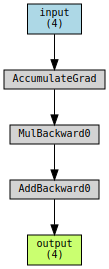

In [9]:
cg = torchviz.make_dot(y, params={"input":x, "output":y})

cg.render("graph", view=True) # save pdf
display(cg) # jupyter note에서 확인.

In [35]:
# x.grad를 초기화하지 않고 다른 loss에서의 grad 계산을 수행시 중첩됨.
y2 = 2*x
y2.backward(torch.ones_like(y2))

display(x.grad) # 앞서의 3과 현재의 2가 더해져 5로 나옴.

tensor([5., 5., 5., 5.])

In [42]:
# 중첩을 막으려면
y3 = 4*x
x.grad.zero_()
print(torch.ones_like(y3))
print(y3)
y3.backward(torch.ones_like(y3))

display(x.grad)

tensor([1., 1., 1., 1.])
tensor([-4., -2.,  0.,  2.], grad_fn=<MulBackward0>)


tensor([4., 4., 4., 4.])

## 주로 사용되는 방법

In [ ]:
# 예제 코드
for data, target in dataset:
    optimizer.zero_grad() # model의 모든 parameters의 grad를 0으로 초기화
    output = model(data)
    loss = loss_function(output, target)
    loss.backward()   # back-propagation을 통해 gradient 계산
    optimizer.step()  # 계산된 gradient를 통해 model의 parameters 갱신 (or 수정).